# Recurrent Neural Networks with Pytorch

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

In [2]:
#export
import torch

In [3]:
def displayImage(url):
    try: return Image(url)
    except: pass

## LSTM Network

In brief, there is...
   + an operation to forget the old output based on the new input.
   + an operation to generate new output based on the hidden state and the new input. 
   + an operation to incorporate the new output into in the new hidden state.

## Encoder - Decoder Network

Basically put two LSTM cells on top of each other. You can convert one sequence into another sequence and this has a particular natural anology in translation. The encoded output of the network is the 'meaning' of the words and the decoded output is the translation.

We can deal the inputs and outputs of variable length by using a start token and an end token.

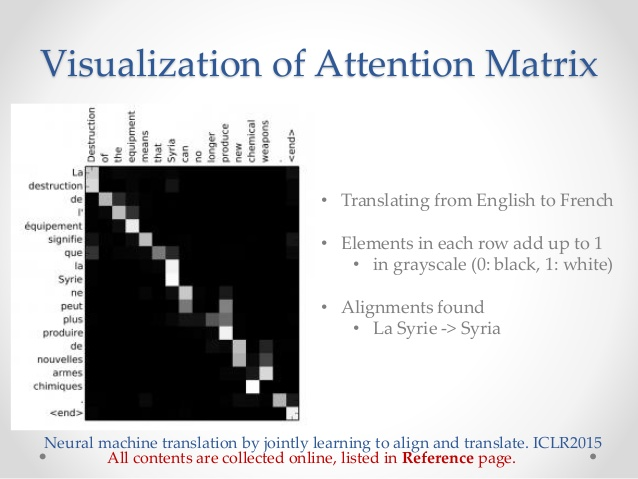

In [4]:
displayImage('https://image.slidesharecdn.com/rnnintro2-161020134201/95/a-brief-introduction-on-recurrent-neural-network-and-its-application-20-638.jpg')

This kind of alignment matrix will tell us what is activated in the output compared what the input was. Plus in french can mean 'more' or 'no longer' or 'longer' or 'add'. We see that produire has a direct translation and therefore gets a stronger activation than plus gets from the same word.

Likewise, predicting words from an image should give an activation on the parts of the image that contribute to that prediction.

Attention is where we use the input encoder LSTM layers to process some encoded input and concatenate it with a hidden state which is passed to the output LSTM cells. Every time an output LSTM decodes some output, we take an operator which does element wise multiplication with the compressed representation of the encoding LSTM cells.

## Reading in movie data

In [5]:
#export
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
import time
import dill

In [6]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [7]:
assert(unicodeToAscii('Montréal') == 'Montreal')

In [8]:
cwd = 'D:/Pytorch Data/cornell_movie_dialogs/'

In [9]:
lines_path = cwd + 'movie_lines.txt'
conv_path = cwd + 'movie_conversations.txt'

In [10]:
with open(lines_path) as file:
    movie_lines = file.readlines()
for line in movie_lines[:8]:
    print(line)

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?

L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.

L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow

L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.

L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No



In [11]:
#export
def extractSplitLine(split_line, line_fields, first_col_id = False):
    if len(split_line) != len(line_fields):
        print('Warning: line', split_line, 'is the wrong length!')
        return
    line_dict = {}
    line_pos = 1 if first_col_id else 0
    for field in line_fields[line_pos:]:
        line_dict[field] = split_line[line_pos]
        line_pos += 1
    return line_dict

def convertLinesToDfs(line_fields, input_lines, separator, first_col_id = False): # boolean makes function dirty
    data_lines = {}
    line_id = 0
    for line in input_lines:
        split_line = line.split(separator)
        line_id = split_line[0] if first_col_id else line_id + 1
        line_dict = extractSplitLine(split_line, line_fields, first_col_id)
        if not line_dict: continue
        data_lines[line_id] = line_dict
    return pd.DataFrame.from_dict(data_lines, orient = 'index')

In [12]:
line_fields = ["lineId", "charId", "movieId", "charName", "text"]
separator = " +++$+++ "
movie_line_df = convertLinesToDfs(line_fields, movie_lines, separator, True)
del movie_lines

In [13]:
movie_line_df.head()

,charId,movieId,charName,text
L1045,u0,m0,BIANCA,They do not!\n
L1044,u2,m0,CAMERON,They do to!\n
L985,u0,m0,BIANCA,I hope so.\n
L984,u2,m0,CAMERON,She okay?\n
L925,u0,m0,BIANCA,Let's go.\n


In [14]:
with open(conv_path) as file:
    conv_lines = file.readlines()
for line in conv_lines[:8]:
    print(line)

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']

u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']



In [15]:
line_fields = ["charId1", "charId2", "movieId", "conversation"]
conv_line_df = convertLinesToDfs(line_fields, conv_lines, separator)
del conv_lines

In [16]:
conv_line_df.head()

,charId1,charId2,movieId,conversation
1,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']\n"
2,u0,u2,m0,"['L198', 'L199']\n"
3,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']\n"
4,u0,u2,m0,"['L204', 'L205', 'L206']\n"
5,u0,u2,m0,"['L207', 'L208']\n"


In [17]:
def processMovieLine(line_string):
    line_string = unicodeToAscii(line_string)
    line_string = line_string.lower()
    line_string = re.sub(r'[ ]', ',', line_string)
    line_string = re.sub(r'[^a-z,!?.]', '', line_string)
    line_string = re.sub(r'[!]', ',!', line_string)
    line_string = re.sub(r'[?]', ',?', line_string)
    line_string = re.sub(r'[.]', ',.', line_string)
    line_string = re.sub(r',,', ',', line_string)
    return line_string.split(',')

In [18]:
processMovieLine(movie_line_df.iloc[5]["text"])

['wow']

In [19]:
movie_line_df['text'] = movie_line_df['text'].apply(processMovieLine)

In [20]:
#export
def processConvLine(conv_string):
    conv_string = re.sub(r'[^,A-Za-z0-9]', '', conv_string)
    return conv_string.split(',')

In [21]:
processConvLine(conv_line_df.iloc[5]['conversation'])

['L271', 'L272', 'L273', 'L274', 'L275']

In [22]:
conv_line_df['conversation'] = conv_line_df['conversation'].apply(processConvLine)

In [23]:
#export
def getBatchRange(i, batch_size, max_len):
    return range(i * batch_size, min((i+1) * batch_size, max_len))

In [24]:
#export
def getAllLinesFromConversations(conversation_dict):
    lines_arr = []
    for conv_list in conversation_dict.values():
        lines_arr.extend(conv_list)
    return lines_arr

def fillUpBatchLinePairs(lines_slice, conv_slice, current_id):
    batch_dict = {}
    for conv in conv_slice.values():
        for j in range(len(conv) - 1):
            line_dict = {}
            line_dict['input'] = lines_slice[conv[j]]
            line_dict['truth'] = lines_slice[conv[j + 1]]
            batch_dict[current_id] = line_dict
            current_id += 1
    return current_id, batch_dict

def makeAllConversationPairs(movie_line_df, conv_line_df, batch_size = 100):
    n_conversations = len(conv_line_df.index)
    n_batches = (n_conversations + batch_size - 1) // batch_size
    data_lines = {}
    current_id = 0
    for i in range(n_batches):
        batch_range = getBatchRange(i, batch_size, n_conversations)
        conv_slice = conv_line_df['conversation'].iloc[batch_range].to_dict()
        lines_included = getAllLinesFromConversations(conv_slice)
        lines_slice = movie_line_df['text'].loc[lines_included].to_dict()
        current_id, batch_dict = fillUpBatchLinePairs(lines_slice, conv_slice, current_id)
        data_lines.update(batch_dict)
    return pd.DataFrame.from_dict(data_lines, orient = 'index')

In [25]:
conv_data_df = makeAllConversationPairs(movie_line_df, conv_line_df)

In [26]:
total_len = 0
for conv_list in conv_line_df['conversation']:
    total_len += len(conv_list)
    total_len -= 1
print(total_len)
assert(total_len == len(conv_data_df))

221616


In [27]:
convertListToStr = lambda x : ' '.join(x)

In [28]:
def exportConversationLists(df, save_name):
    df['input'] = df['input'].apply(convertListToStr)
    df['truth'] = df['truth'].apply(convertListToStr)
    df.to_csv(cwd + '/' + save_name, header = True, index = True)

## Process Vocabulary

In [29]:
conv_data_df.head()

,input,truth
0,"[can, we, make, this, quick, ?, roxanne, korri...","[well, i, thought, wed, start, with, pronuncia..."
1,"[well, i, thought, wed, start, with, pronuncia...","[not, the, hacking, and, gagging, and, spittin..."
2,"[not, the, hacking, and, gagging, and, spittin...","[okay, ., ., ., then, how, bout, we, try, out,..."
3,"[youre, asking, me, out, ., thats, so, cute, ....","[forget, it, .]"
4,"[no, no, its, my, fault, we, didnt, have, a, p...","[cameron, .]"


In [30]:
last_train_index = int(len(conv_data_df) * 0.9)

In [31]:
#export
SPAM_TOKEN = 0
START_TOKEN = 1
END_TOKEN = 2
FLUFF_TOKEN = 3

class Vocabulary:
    def __init__(self, name, last_train, load_size = 100, stop_words = ['.', '?', '!']):
        self.name = name
        self.last_train = last_train
        self.load_size = load_size
        self.stop_words = stop_words
        self.resetDictionaries()
        
    def resetDictionaries(self):
        self.word_2_index = {}
        self.word_2_count = {}
        self.index_2_word = {SPAM_TOKEN:'_spam_', END_TOKEN:'_end_', FLUFF_TOKEN:'_fluff_', START_TOKEN: '_start_'}
        self.nr_words = 4
        
    def addEntry(self, entry):
        for word in entry:
            if word in self.word_2_index.keys():
                self.word_2_count[word] += 1
            else:
                self.word_2_index[word] = self.nr_words
                self.index_2_word[self.nr_words] = word
                self.word_2_count[word] = 1
                self.nr_words += 1
            if word in self.stop_words: break
                
    def addAllEntries(self, df, col):
        n_batches = (self.last_train + self.load_size - 1) // self.load_size
        for k in range(n_batches):
            batch_range = getBatchRange(k, self.load_size, self.last_train)
            conv_slice = df[col].iloc[batch_range].to_dict()
            for entry in conv_slice.values():
                self.addEntry(entry)
    
    def countEntry(self, entry):
        entry_count = 0
        for word in entry:
            if word in self.word_2_index.keys():
                entry_count += 1
                if word in self.stop_words: break
        return entry_count
    
    def getLongestSentence(self, df):
        n_batches = (len(df) + self.load_size - 1) // self.load_size
        max_count = 0
        for col in df.columns:
            for k in range(n_batches):
                batch_range = getBatchRange(k, self.load_size, len(df))
                conv_slice = df[col].iloc[batch_range].to_dict()
                for entry in conv_slice.values():
                    entry_count = self.countEntry(entry)
                    if entry_count > max_count: max_count = entry_count
        return max_count
                
    def removeBelowThreshold(self, thresh : int):
        new_word_2_index = {}
        new_word_2_count = {}
        new_index_2_word = {SPAM_TOKEN:'_spam_', END_TOKEN:'_end_', FLUFF_TOKEN:'_fluff_', START_TOKEN: '_start_'}
        k = 4
        current_index = 4
        for k in range(4, self.nr_words):
            word = self.index_2_word[k]
            word_count = self.word_2_count[word]
            if word_count > thresh:
                new_word_2_index[word] = current_index
                new_index_2_word[current_index] = word
                new_word_2_count[word] = word_count
                current_index += 1
        self.word_2_index = new_word_2_index
        self.word_2_count = new_word_2_count
        self.index_2_word = new_index_2_word
        self.nr_words = current_index

    def plotFrequencyHist(self, cut_off : int):
        freq_dist = [val for val in self.word_2_count.values() if val < cut_off]
        total_freq = sum(self.word_2_count.values())
        if total_freq > 0: total_freq = sum(freq_dist)/total_freq
        sns.distplot(freq_dist, color='y', kde = False)
        plt.title(label = "Showing {}% of all words".format(np.round(total_freq * 100, 1)))
        plt.xlabel("Words ordered by ascending frequency")
        plt.ylabel("Number of words")
        plt.show()
        
    def containsWord(self, word : str):
        return word in self.word_2_index.keys()

    def __len__(self):
        return self.nr_words
    
    def __call__(self, value):
        if value in self.word_2_index.keys():
            return self.word_2_index[value]
        return SPAM_TOKEN

In [32]:
cut_off = 4

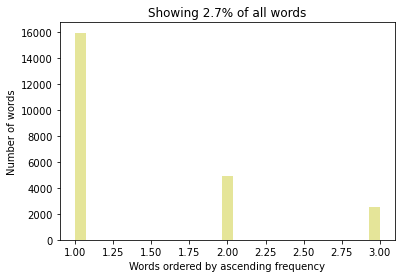

In [33]:
movie_vocab = Vocabulary('MOVIE_CONV', last_train_index)
movie_vocab.addAllEntries(conv_data_df, 'input')
movie_vocab.plotFrequencyHist(cut_off)

In [34]:
movie_vocab.removeBelowThreshold(cut_off)

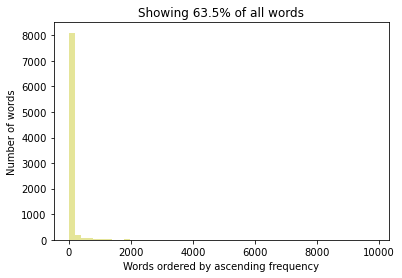

In [35]:
movie_vocab.plotFrequencyHist(10000)

In [36]:
vocab_size = len(movie_vocab); print(vocab_size)

8618


In [37]:
longest_sentence = movie_vocab.getLongestSentence(conv_data_df); print(longest_sentence)

104


## Building a batch generator

The previous class is an object that just converts a number into a word we can read and visa versa. This second container class will use the vocabulary to generate batches that the neural network can read.

In [38]:
#export
class ConversationBatchGenerator:
    def __init__(self, vocabulary : Vocabulary, batch_size : int, max_sentence_len: int):
        self.vocab = vocabulary
        self.batch_size = batch_size
        self.max_sentence_len = max_sentence_len
        self.input = torch.zeros((max_sentence_len, batch_size), dtype = torch.int64)
        self.input[0, :] = START_TOKEN
        self.input_lens = torch.zeros(batch_size, dtype = torch.int32)
        self.label = torch.zeros((max_sentence_len, batch_size), dtype = torch.int64)
        self.label[0, :] = START_TOKEN
        self.label_mask = torch.zeros((max_sentence_len, batch_size), dtype = torch.bool)
        self.label_lens = torch.ones(batch_size, dtype = torch.int32)

    def tokenizeEntry(self, out_tensor, out_lens, entry, current_ind):
        w_ind = 1
        entry_len = len(entry)
        sentence_len = out_tensor.shape[0]
        while w_ind < sentence_len:
            if not w_ind < entry_len: break
            word = entry[w_ind - 1]
            if word in self.vocab.word_2_count.keys():
                out_tensor[w_ind, current_ind] = self.vocab.word_2_index[word]
            else:
                out_tensor[w_ind, current_ind] = SPAM_TOKEN
            w_ind += 1
            if word in self.vocab.stop_words: break
        out_lens[current_ind] = w_ind      
        if w_ind < sentence_len:
            out_tensor[w_ind, current_ind] = END_TOKEN
            w_ind += 1
        while w_ind < sentence_len:
            out_tensor[w_ind, current_ind] = FLUFF_TOKEN
            w_ind += 1

    def fillTensorFromBatch(self, out_tensor, out_lens, df, batch_range, col):
        df_slice = df[col].loc[batch_range].to_dict()
        current_ind = 0
        for entry in df_slice.values():
            self.tokenizeEntry(out_tensor, out_lens, entry, current_ind)
            current_ind += 1

    def sortOutputByInputLen(self):
        self.input_lens, input_order = self.input_lens.sort()
        self.input_lens = reversed(self.input_lens)
        input_order = reversed(input_order)
        self.input = self.input[:, input_order]
        self.label = self.label[:, input_order]
        self.label_mask = self.label_mask[:, input_order]
            
    def getTokenizedBatch(self, df, start_ind, data_col, label_col = None, shuffled_ind = None):
        n_batches = (len(df) + self.batch_size - 1) // self.batch_size
        if shuffled_ind is None:
            batch_range = getBatchRange(start_ind, self.batch_size, len(df))
        else:
            batch_range = shuffled_ind[getBatchRange(start_ind, self.batch_size, len(df))]

        self.fillTensorFromBatch(self.input, self.input_lens, df, batch_range, data_col)
        label_out = None
        label_lens = None

        if label_col:
            self.fillTensorFromBatch(self.label, self.label_lens, df, batch_range, label_col)
            self.label_mask = self.label != FLUFF_TOKEN
            #self.sortOutputByInputLen() -- small speed up when enforced
            return self.input, self.input_lens, self.label, self.label_mask
        else:
            return self.input, self.input_lens

    def printTensorRow(self, row_ind, in_tensor):
        if row_ind > self.batch_size -1: print('Index requested exceeds batch size.'); return
        if row_ind < 0: print('Index requested is negative.'); return
        tensor_row = in_tensor[:, row_ind]
        sentence = ''
        second_word = True
        for embedded_word in tensor_row:
            word_index = int(embedded_word)
            word = self.vocab.index_2_word[word_index]
            if word_index != START_TOKEN and second_word:
                second_word = False
                word = ' ' + word
                if len(word) > 1:
                    word = ' ' + word[1].upper() + word[2:]
            else:
                sentence += ' '
            sentence += word
        sentence = re.sub(r' \!', '!', sentence)
        sentence = re.sub(r' \?', '?', sentence)
        sentence = re.sub(r' \.', '.', sentence)
        return sentence
    
    def printInputRow(self, row_ind: int):
        return self.printTensorRow(row_ind, self.input)

    def printLabelRow(self, row_ind: int):
        return self.printTensorRow(row_ind, self.label)

    def putBatchesOnGPU(self):
        self.input = self.input.cuda()
        self.input_lens = self.input_lens.cuda()
        self.label = self.label.cuda()
        self.label_mask = self.label_mask.cuda()
    
    def takeBatchesOffGPU(self):
        self.input = self.input.cpu()
        self.input_lens = self.input_lens.cpu()
        self.label = self.label.cpu()
        self.label_mask = self.label_mask.cpu()

In [39]:
sentence_limit = 20
batch_size = 16

In [40]:
train_df = conv_data_df.loc[conv_data_df.index[:last_train_index]]
valid_df = conv_data_df.loc[conv_data_df.index[last_train_index:]]

In [41]:
batch_generator = ConversationBatchGenerator(movie_vocab, batch_size, sentence_limit)

In [42]:
in_tensor, input_lens, label_tensor, label_mask = batch_generator.getTokenizedBatch(train_df, 0, 'input', 'truth')

In [43]:
in_tensor.shape

torch.Size([20, 16])

In [44]:
batch_generator.printInputRow(5)

' _start_ Cameron _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_'

In [45]:
batch_generator.printLabelRow(5)

' _start_ The thing is cameron im at the mercy of a particularly hideous breed of loser. _end_ _fluff_ _fluff_'

In [46]:
assert(np.linalg.norm(np.array(in_tensor.shape) - (sentence_limit, batch_size) == 0.))

In [47]:
assert(np.linalg.norm(np.array(label_tensor.shape) - (sentence_limit, batch_size) == 0.))

In [48]:
in_tensor.device

device(type='cpu')

In [49]:
input_lens[5]

tensor(2, dtype=torch.int32)

In [50]:
label_mask[:,5]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       dtype=torch.uint8)

In [51]:
input_lens

tensor([ 7, 13, 10,  6, 12,  2, 17,  2,  4, 11,  5,  3, 12,  8, 12,  2],
       dtype=torch.int32)

In [52]:
assert(np.linalg.norm(np.array(label_mask.shape) - (sentence_limit, batch_size)) == 0.)

## Building the Model

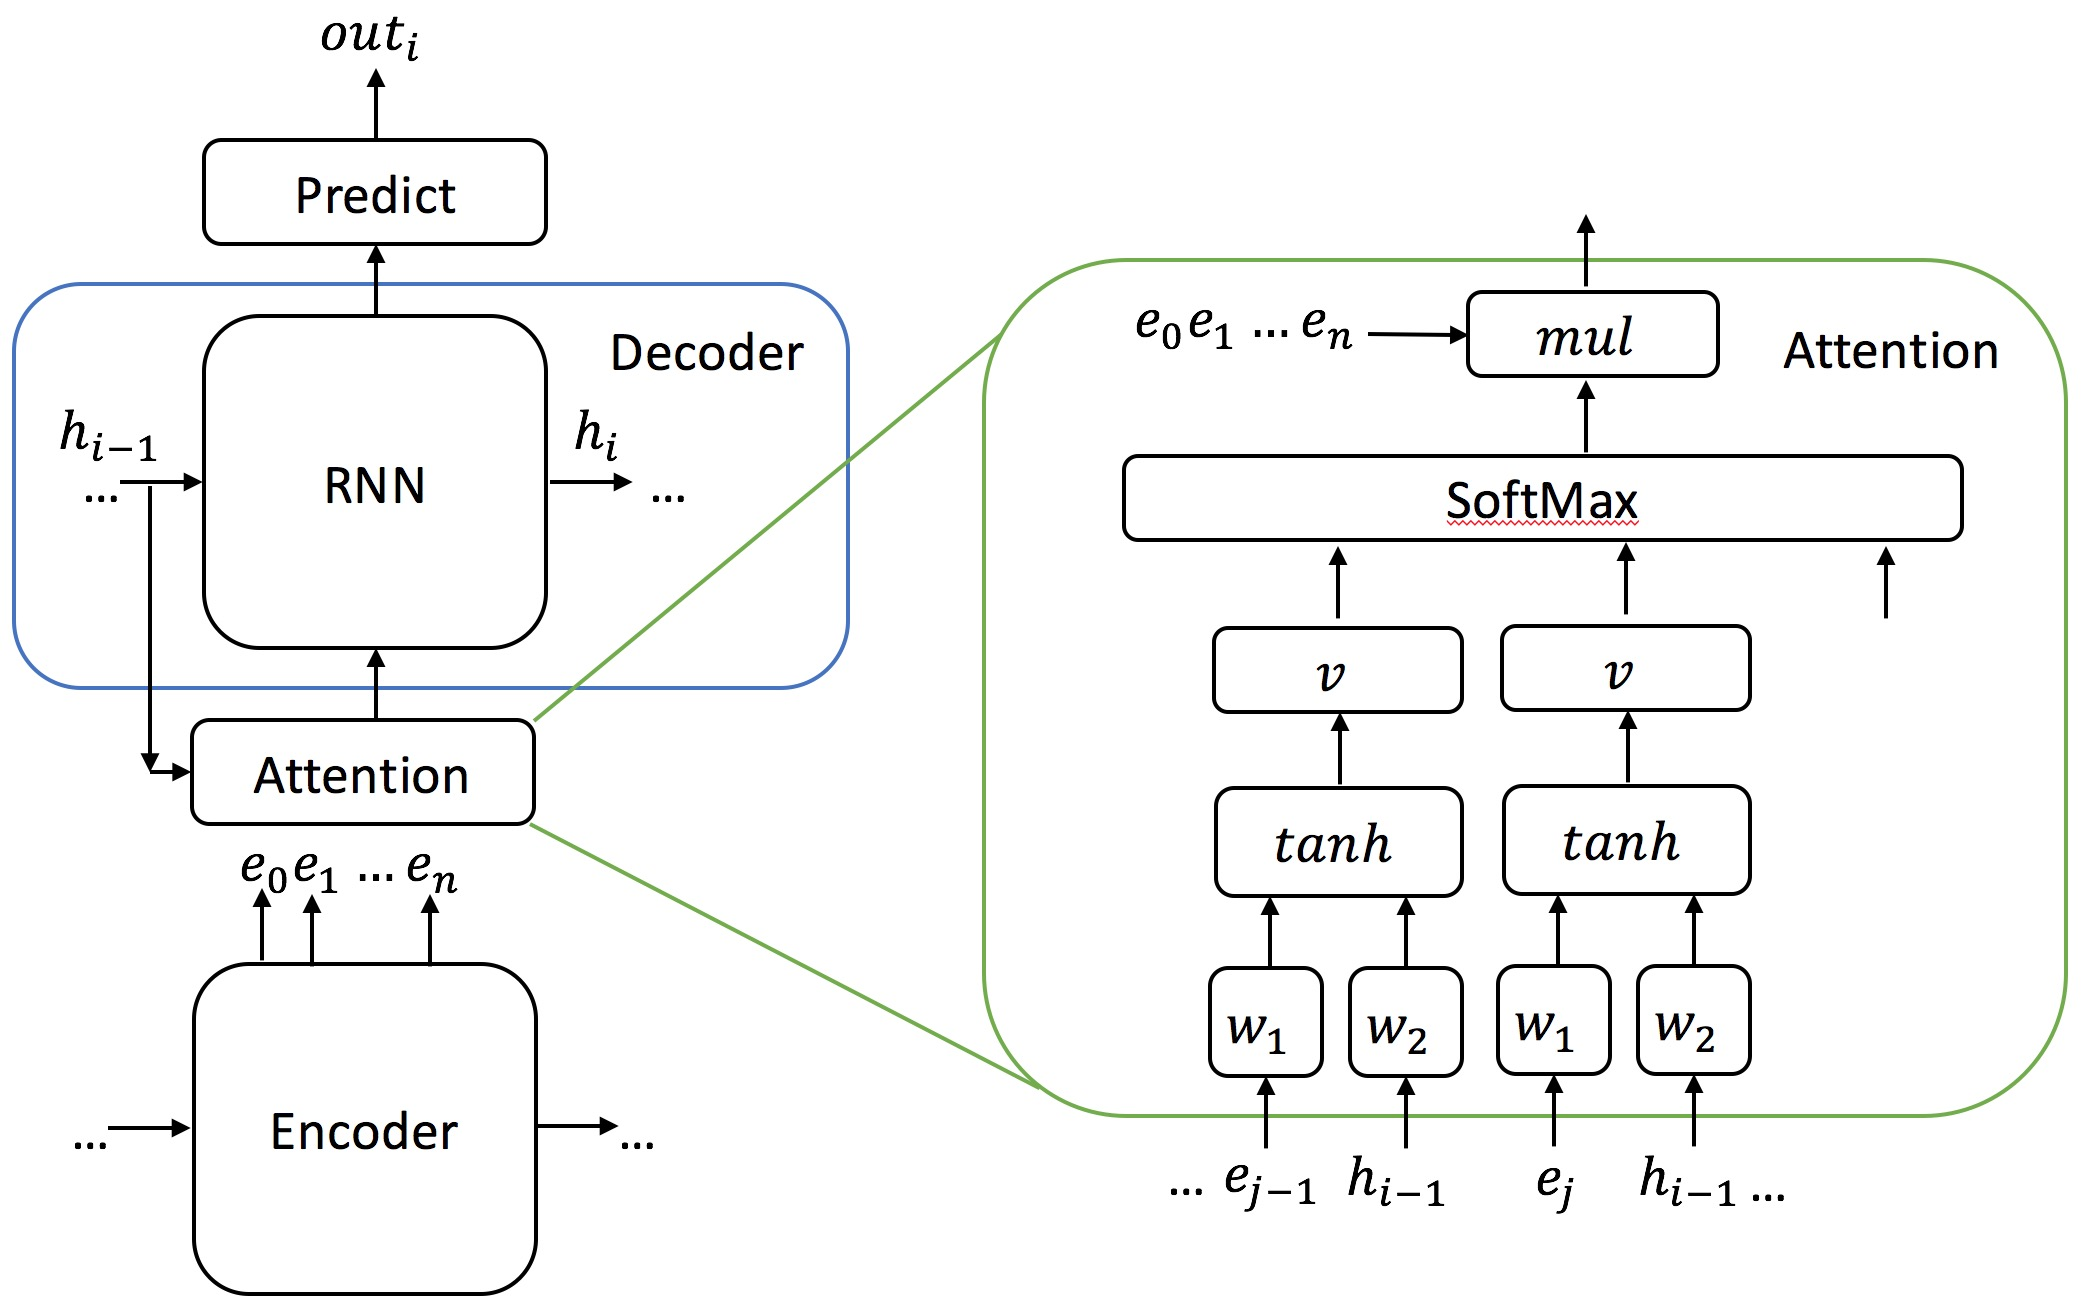

In [53]:
displayImage("https://talbaumel.github.io/blog/attention/img/att.jpg")

This module will define the encoder part of the model which can be stacked on top of one another. Since it is bi-directional the sum of the two outputs can be added to get the information from two points of view.

In [54]:
#export
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers = 1, dropout = 0):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.dropout = 0 if n_layers == 1 else dropout
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout = self.dropout, bidirectional=True)
        
    def forward(self, input_batch, input_lens, hidden = None):
        embedded_input = self.embedding(input_batch)
        input_packed = nn.utils.rnn.pack_padded_sequence(embedded_input, input_lens, batch_first = False, enforce_sorted=False)
        outputs, hidden = self.gru(input_packed, hidden) # hidden is (1, batch_size, hidden_size)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs) # (2 * n_layers, n_batch, n_hidden)
        # Sum birdirectional parts of the network, which is why n_layers was multiplied by 2
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        return outputs, hidden

The attention module is like a convolutional layer that provides both high and low level context for the model.

In [55]:
#export
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super().__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        if method == "general":
            self.attn = nn.Linear(hidden_size, hidden_size)
        elif method == "concat":
            self.attn = nn.Linear(hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
   
    def dotScore(self, hidden, enc_output):
        # Dot product over hidden size and word dimension is broadcasted
        return torch.sum(hidden * enc_output, dim = 2)
    
    def generalScore(self, hidden, enc_output):
        energy = self.attn(enc_output)
        return torch.sum(hidden * energy, dim=2)

    def concatScore(self, hidden, enc_output):
        energy = self.attn(torch.cat((hidden.expand(enc_output.size(0), -1, -1), enc_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def produceScoreFromEnum(self, hidden, enc_output):
        if self.method == "general":
            return self.generalScore(hidden, enc_output)
        elif self.method == "concat":
            return self.concatScore(hidden, enc_output)
        return self.dotScore(hidden, enc_output)
    
    def forward(self, hidden, enc_output):
        # hidden shape : (1, batch_size, hidden_size)
        # encoder : (sentence_len, batch_size, hidden_size)
        attention_energies = self.produceScoreFromEnum(hidden, enc_output) # (sentence_len, batch_size)
        attention_energies = attention_energies.t() # (batch_size, sentence_len)
        return F.softmax(attention_energies, dim = 1).unsqueeze(1) # (batch_size, 1, sentence_len)

Finally put it all togehter. In the decoder module?

In [56]:
#export
class DecoderRNN(nn.Module):
    def __init__(self, att_model_type, embedding, hidden_size, output_size, n_layers = 1, dropout = 0.05, transfer = False):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        gru_dropout = 0 if n_layers == 1 else dropout
        self.decoder_gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout = gru_dropout)
        
        concat_size  = 1200 if transfer else 0
        concat_size += hidden_size * 2
        self.concat  = nn.Linear(concat_size, hidden_size)
        
        self.out = nn.Linear(hidden_size, output_size)
        
        self.attention = Attention(att_model_type, hidden_size)
        
    def forward(self, input_step, prev_hidden, current_encoded_outputs, transfer_learned_outputs = None):

        # encode
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)

        # decode using previous hidden state and encode
        rnn_output, hidden = self.decoder_gru(embedded, prev_hidden)

        # Create attention weights representation
        attn_weights = self.attention(rnn_output, current_encoded_outputs)

        # Concatenate context and latest rnn output 
        context = attn_weights.bmm(current_encoded_outputs.transpose(0, 1)) # Bath matrix multiply
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)

        # both context and hidden output (batch_size * hidden_size)
        if transfer_learned_outputs:
            pass # ToDo add transfer learned model here
        else:
            concat_input = torch.cat((rnn_output, context), 1)

        # regular deep network form here forward 
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim = 1) # ToDo look at removing this

        return output, hidden

## Other objects for the training

The loss must be masked becuase there is limited input length.

In [57]:
#export
def maskedNegLogLikeLoss(decoder_output, target, mask):
    if mask.sum() == 0:
        print('Empty mask input!')
        loss = torch.tensor(0)
        loss.cuda()
        return loss, 0
    nTotal = mask.sum()
    target = target.unsqueeze(1)
    gathered_tensor = torch.gather(decoder_output, 1, target)
    gathered_tensor = gathered_tensor.squeeze(1)
    cross_entropy = -torch.log(gathered_tensor)
    loss = cross_entropy.masked_select(mask)
    loss = loss.mean()
    loss = loss.cuda()
    return loss, nTotal.item() # item expresses a pytorch single element tensor in its python equivalent

Teacher forcing is also intorcued. Regardless of whether the correct word was selected in the previous time step, we force the input data to refelct a correct response so no time is wasted on learning from junk. Perhaps there should be a gradual decline in teacher forcing? This is something that can be looked at.

## Test One Loop

Example training iteration

In [58]:
batch_generator.putBatchesOnGPU()
in_tensor, input_lens, label_tensor, mask = batch_generator.getTokenizedBatch(conv_data_df, 0, 'input', 'truth')

In [59]:
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
embedding = nn.Embedding(len(movie_vocab), hidden_size)

encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = DecoderRNN('dot', embedding, hidden_size, len(movie_vocab), decoder_n_layers, dropout)
encoder.cuda()
decoder.cuda()

# Tells the encoder and decoder that it is training time
# Dropout and batch norms do not behave same way at run time
encoder.train()
decoder.train()

encoder_optimizer = optim.Adam(encoder.parameters(), lr = 1e-4)
decoder_optimizer = optim.Adam(decoder.parameters(), lr = 1e-4)

In [60]:
clipping_amount = 100

In [61]:
max_output_len = mask.sum(dim = 0).max().item()

In [62]:
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()
max_sentence_len = input_lens[0].item()

for epoch in range(5):
    loss = 0
    nr_items = 0

    encoder_outputs, encoder_hidden = encoder(in_tensor, input_lens)
    decoder_input = torch.LongTensor([[START_TOKEN for _ in range(batch_size)]])
    decoder_input = decoder_input.cuda()
    decoder_hidden = encoder_hidden[:decoder_n_layers]

    for t in range(max_output_len):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_input = label_tensor[t].view(1, -1) # teacher forcing
        mask_loss, n = maskedNegLogLikeLoss(decoder_output, label_tensor[t], mask[t])
        loss += mask_loss
        nr_items += n
    
    loss.backward()
    
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clipping_amount)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clipping_amount)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    print("Average loss", loss.item()/nr_items)

Average loss 1.2819806196558194
Average loss 1.274983924204909
Average loss 1.2670415442759597
Average loss 1.2584599772776206
Average loss 1.2499256284218134


In [63]:
nr_items

127

In [64]:
assert(np.linalg.norm(np.array(encoder_outputs.shape) - (input_lens.max().item(), batch_size, hidden_size)) == 0)

In [65]:
assert(np.linalg.norm(np.array(encoder_hidden.shape) - (encoder_n_layers + decoder_n_layers, batch_size, hidden_size)) == 0)

In [66]:
assert(np.linalg.norm(np.array(decoder_hidden.shape) - (decoder_n_layers, batch_size, hidden_size)) == 0.)

In [67]:
assert(np.linalg.norm(np.array(decoder_input.shape) - (1, batch_size)) == 0.)

In [68]:
assert(np.linalg.norm(np.array(decoder_output.shape) - (batch_size, len(movie_vocab))) == 0.)

In [69]:
assert(np.linalg.norm(np.array(embedding(label_tensor[t]).shape) - (batch_size, hidden_size)) == 0.)

In [70]:
def outputSentenceFromBatch(batch_ind):
    batch_ind %= batch_size
    encoder_outputs, encoder_hidden = encoder(in_tensor, input_lens)
    decoder_input = torch.LongTensor([[START_TOKEN for _ in range(batch_size)]])
    decoder_input = decoder_input.cuda()
    decoder_hidden = encoder_hidden[:decoder_n_layers]
    for t in range(sentence_limit):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        _, predicted_words = decoder_output.topk(1)
        decoder_input = torch.LongTensor([[predicted_words[i][0] for i in range(batch_size)]])
        decoder_input = decoder_input.cuda() # no teacher forcing
        print(
            movie_vocab.index_2_word[decoder_output[batch_ind].argmax().item()], 
            movie_vocab.index_2_word[label_tensor[t, batch_ind].item()]
        )

This took a lot of epochs. The fact no transfer learning is used here at all is an issue. Also not that the model has never seen any fluff, and it doesn't care about fluff so it is not capable of producing any fluff and the sentence should stop at `_end_`.

`
_start_ _start_
seems seems
like like
she she
could could
get get
a a
date date
easy easy
enough enough
. .
_end_ _end_
_end_ _fluff_
_end_ _fluff_
_end_ _fluff_
_end_ _fluff_
_end_ _fluff_
_end_ _fluff_
`

In [71]:
del encoder, decoder, decoder_input, decoder_hidden, decoder_output, encoder_outputs, encoder_hidden
del embedding, encoder_optimizer, decoder_optimizer
torch.cuda.empty_cache()

## Create a Class For the Model

The chaotbot can now be made which puts all the model computation into one function.

In [72]:
#export
class ChatBot(nn.Module):
    def __init__(self, hidden_size, encoder_n_layers, decoder_n_layers, dropout, att_type, vocab, batch_size, max_output_len):
        super().__init__()
        self.model_on_GPU = False
        
        self.hidden_size = hidden_size
        self.encoder_n_layers = encoder_n_layers
        self.decoder_n_layers = decoder_n_layers
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.batch_size = batch_size
        self.max_output_len = max_output_len
        
        self.embedding = nn.Embedding(len(vocab), hidden_size)
        self.encoder = EncoderRNN(hidden_size, self.embedding, encoder_n_layers, dropout)
        self.decoder = DecoderRNN(att_type, self.embedding, hidden_size, self.vocab_size, decoder_n_layers, dropout)
        
        self.can_teacher_force = True
        self.teacher_force_prob = 1
        
        self.training_mode = True
        self.putIntoTrainingMode()
        
        self.infer_input_length = torch.ones(batch_size, dtype = torch.long)
        self.infer_input_tensor = torch.zeros((max_output_len, batch_size), dtype = torch.long)
        
    def getParameters(self):
        return self.encoder.parameters(), self.decoder.parameters()
    
    def putIntoTrainingMode(self):
        self.training_mode = True
        self.encoder.train()
        self.decoder.train()
    
    def putIntoValidationMode(self):
        self.training_mode = False
        self.encoder.eval()
        self.decoder.eval()
    
    def putModelOntoGPU(self):
        self.model_on_GPU = True
        self.encoder = self.encoder.cuda()
        self.decoder = self.decoder.cuda()

    def putModelOntoCPU(self):
        self.model_on_GPU = False
        self.encoder = self.encoder.cpu()
        self.decoder = self.decoder.cpu()
        
    def getInitialEncoderDecoderInput(self, in_tensor, input_lens):
        encoder_outputs, encoder_hidden = self.encoder(in_tensor, input_lens)
        decoder_input = torch.LongTensor([[START_TOKEN for _ in range(self.batch_size)]])
        if self.model_on_GPU: decoder_input = decoder_input.cuda()
        decoder_hidden = encoder_hidden[:self.decoder_n_layers]
        return decoder_input, decoder_hidden, encoder_outputs
    
    def setTeacherForceProb(self, value):
        self.can_teacher_force = value > 0 
        self.teacher_force_prob = value
    
    def useTeacherForce(self):
        if not self.can_teacher_force: return False
        return np.random.random() < self.teacher_force_prob

    def getDecoderInputForNextBatch(self, decoder_output):
        _, predicted_words = decoder_output.topk(1)
        decoder_input = torch.LongTensor([[predicted_words[i][0] for i in range(self.batch_size)]])
        if self.model_on_GPU: decoder_input = decoder_input.cuda()
        return decoder_input
    
    def calculateTrainingLoss(self, decoder_input, decoder_hidden, encoder_outputs, label, mask, max_sentence_len):
        loss, nr_items = 0, 0
        
        for i in range(max_sentence_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            if self.useTeacherForce():
                decoder_input = label[i].view(1, -1)
            else:
                decoder_input = self.getDecoderInputForNextBatch(decoder_output)
            
            mask_loss, nr = maskedNegLogLikeLoss(decoder_output, label[i], mask[i])
            loss += mask_loss
            nr_items += nr
        
        return loss, nr_items
    
    def calculateWordOutput(self, decoder_input, decoder_hidden, encoder_outputs):
        output_words = []
        
        for _ in range(self.max_output_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = self.getDecoderInputForNextBatch(decoder_output)
            
            output_words.append(
                [self.vocab.index_2_word[decoder_output[i].argmax().item()] for i in range(self.batch_size)]
            )
        
        return output_words

    def getMaxOutputLen(self, mask):
        return mask.sum(dim = 0).max().item()
    
    def forward(self, in_tensor, input_lens, label = None, mask = None):
        
        decoder_input, decoder_hidden, encoder_outputs = self.getInitialEncoderDecoderInput(in_tensor, input_lens)

        if not label is None and not mask is None:
            max_sentence_len = self.getMaxOutputLen(mask)
            return self.calculateTrainingLoss(decoder_input, decoder_hidden, encoder_outputs, label, mask, max_sentence_len)
        else:
            if self.training_mode : print('Warning! : Model is called with no labels in training mode!')
            return self.calculateWordOutput(decoder_input, decoder_hidden, encoder_outputs)

    def createWordTensor(self, sentence_list):
        integer_list = [START_TOKEN] + [self.vocab(w) for w in sentence_list] + [END_TOKEN]
        self.infer_input_length[0] = len(integer_list)

        input_ind = 0
        for value in integer_list:
            self.infer_input_tensor[0, input_ind] = value
            input_ind += 1
            
        output_batch = self.forward(self.infer_input_tensor, self.infer_input_length)
        words = [output_batch[i][0] for i in range(self.max_output_len)]
        words = words[1:words.index('_end_')]
        words = ' '.join(words)
        words = words[0].upper() + words[1:] 
        return words

    def predict(self, sentence):
        sentence_list = processMovieLine(sentence)
        
        penultimate_word_ind = self.max_output_len - 2
        if len(sentence_list) >= penultimate_word_ind:
            sentence_list = sentence_list[:penultimate_word_ind]
        
        return self.createWordTensor(sentence_list)

In [73]:
chat_bot = ChatBot(hidden_size, encoder_n_layers, decoder_n_layers, dropout, 'dot', movie_vocab, batch_size, sentence_limit)

In [74]:
chat_bot.putModelOntoGPU()

In [75]:
encoder_params, decoder_params = chat_bot.getParameters()

In [76]:
encoder_optimizer = optim.Adam(encoder_params, lr = 1e-4)
decoder_optimizer = optim.Adam(decoder_params, lr = 1e-4)

In [77]:
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

In [78]:
for epoch in range(5):
    
    loss, nr_items = chat_bot(in_tensor, input_lens, label_tensor, mask)
    
    loss.backward()
    
    _ = nn.utils.clip_grad_norm_(encoder_params, clipping_amount)
    _ = nn.utils.clip_grad_norm_(decoder_params, clipping_amount)
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    print("Epoch", epoch,"Average loss", loss.item()/nr_items)

Epoch 0 Average loss 1.2839739942175197
Epoch 1 Average loss 1.2759327325295275
Epoch 2 Average loss 1.2670569232129676
Epoch 3 Average loss 1.2561188945620079
Epoch 4 Average loss 1.2443368265947958


In [79]:
chat_bot.putIntoValidationMode()

In [80]:
output_words = chat_bot(in_tensor, input_lens)

After 360 epochs there is the following output...

`[output_words[i][0] for i in range(sentence_limit)]`

`['_start_',
 'seems',
 'like',
 'she',
 'could',
 'get',
 'a',
 'date',
 'easy',
 'enough',
 '.',
 '_end_',
 '_end_',
 '_end_',
 '_end_',
 '_end_',
 'of',
 '_end_',
 '.',
 '_end_']
`

In [81]:
del chat_bot, encoder_params, decoder_params, encoder_optimizer, decoder_optimizer
torch.cuda.empty_cache()

## Create Iterator Class

In [82]:
def createSpamFindingFunction(vocab : Vocabulary):
    return lambda x : not(SPAM_TOKEN in [vocab(e) for e in x])

In [83]:
def createTooLongSentenceFunction(sentence_len : int):
    return lambda x : len(x) <= sentence_len

In [84]:
#export
class BatchIterator:
    def __init__(self, df, batch_size, sentence_limit, vocab, inp_col, lbl_col, 
                       shuffle = False, remove_spam = True, remove_no_end = True):
        self.df = df
        self.batch_size = batch_size
        self.sentence_limit = sentence_limit
        self.vocab = vocab
        
        self.inp_col = inp_col
        self.lbl_col = lbl_col
        
        if remove_spam:
            self.df = self.removeEntriesWithSpam(self.df)
            
        if remove_spam:
            self.df = self.removeEntriesWithNoEnd(self.df)
            
        self.shuffle_ind = np.array(self.df.index)
        if shuffle:
            np.random.shuffle(self.shuffle_ind)
        self.n_batches = len(self.df) // batch_size
            
        self.generator = ConversationBatchGenerator(vocab, batch_size, sentence_limit)
            
    def __iter__(self):
        for i in range(self.n_batches):
            yield self.generator.getTokenizedBatch(self.df, i, self.inp_col, self.lbl_col, self.shuffle_ind)
    
    def __len__(self):
        return self.n_batches

    def removeEntriesWithSpam(self, df):
        spamFinding = createSpamFindingFunction(self.vocab)

        input_has_spam = df[self.inp_col].apply(spamFinding)
        label_has_spam = df[self.lbl_col].apply(spamFinding)
        either_has_spam = np.logical_and(input_has_spam, label_has_spam)

        return df.loc[either_has_spam]

    def removeEntriesWithNoEnd(self, df):
        longFinding = createTooLongSentenceFunction(self.sentence_limit)
        
        input_too_long = df[self.inp_col].apply(longFinding)
        label_too_long = df[self.lbl_col].apply(longFinding)
        either_too_long = np.logical_and(input_too_long, label_too_long)

        return df.loc[either_too_long]
            
    def printInputRow(self, ind):
        return self.generator.printInputRow(ind)

    def printLabelRow(self, ind):
        return self.generator.printLabelRow(ind)
    
    def putBatchesOnGPU(self):
        self.generator.putBatchesOnGPU()
        
    def takeBatchesOffGPU(self):
        self.generator.takeBatchesOffGPU()

In [85]:
train_iter = BatchIterator(train_df, 16, 20, movie_vocab, 'input', 'truth', True, True, True)

In [86]:
next(train_iter.__iter__());

In [87]:
train_iter.printInputRow(13)

' _start_ Want you to remember this moment riddick. _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_'

In [88]:
train_iter.printLabelRow(13)

' _start_ Say that again _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_'

In [89]:
valid_iter = BatchIterator(valid_df, 16, 20, movie_vocab, 'input', 'truth', True)

Without any model training the loop takes 179 seconds.

`
start_time = time.time()
for bat in batch_iter: pass
delta_time = time.time() - start_time
print(np.round(delta_time, 3))
`

In [90]:
len(train_iter)

5650

## Cyclical learning rate generator

A cyclical learning rate cycles between two learning rates and can also involve a decaying learning rate as well.

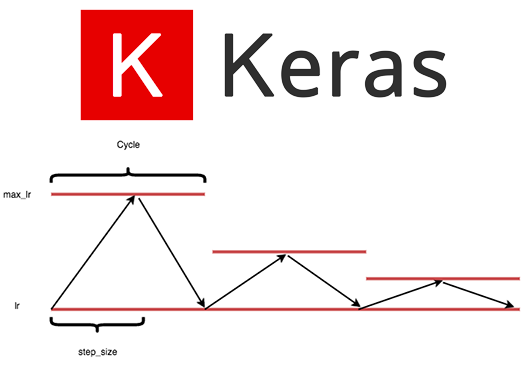

In [91]:
displayImage("https://pyimagesearch.com/wp-content/uploads/2019/07/keras_clr_header.png")

In [92]:
def generateTriangleCycle(min_value : float, max_value : float, cycle_period : int, offset : int = 0):
    mid_cycle      = cycle_period // 2
    max_value_gain = max_value - min_value
    f = lambda x, e : min_value + abs(mid_cycle - (e + mid_cycle - offset) % cycle_period) / mid_cycle * max_value_gain
    return f

In [93]:
def generateTriangleCycle2(min_value : float, max_value : float, cycle_period : int, offset : int = 0):
    g = generateTriangleCycle(0., max_value - min_value, cycle_period, offset)
    f = lambda x, e : min_value + g(x, e) * 0.5 ** (e // cycle_period)
    return f

In [94]:
def generateTriangleCycleExp(min_value : float, max_value : float, cycle_period : int, decay_rate : float, offset : int = 0):
    g = generateTriangleCycle(0., max_value - min_value, cycle_period, offset)
    f = lambda x, e : min_value + g(x, e) * np.exp(1) ** (-decay_rate * (e // cycle_period))
    return f

In [95]:
def generateDecayFunction(decay_rate : float, batch_per_epoch : int):
    return lambda x, e: x * decay_rate ** (1 / batch_per_epoch)

## Create Training Loop

The remaining code can refctored into a single training loop function that outputs validation and training accracy in some tuples and saves each model and its stats to a designated location.

In [102]:
params = {'21-11-20_FullDataset8wordsSentences' : {
    'shuffle' : False,
    'remove_spam' : True,
    'remove_no_end' : True,
    'batch_size' : 64,
    'skip_batch' : 1,
    'hidden_size' : 500,
    'encoder_n_layers' : 2,
    'decoder_n_layers' : 2,
    'dropout' : .1,
    'sentence_limit' : 8,
    'att_model_type' : 'general',
    'n_epochs' : 100,
    'encoder_lr': 4e-4,
    'decoder_lr': 4e-3,
    'clipping_ammount': 50.,
    'teacher_force_prob': 0.5,
    'reload_model': True,
    'encoder_lr_func': generateTriangleCycleExp(1e-5, 1e-4, 150, 0.025),
    'decoder_lr_func': generateTriangleCycleExp(5e-4, 5e-3, 150, 0.025),
    'clipping_func': lambda x, e : x,
    'teacher_force_func': generateTriangleCycleExp(0.75, 0.95, 100, 0.025, 50),
    'use_GPU' : True,
    'use_validation' : False,
}}

In [103]:
#export
class ModelRunner:
    def __init__(self, train_df, valid_df, vocab, params, inp_col, lbl_col, folder):
        self.train_df = train_df
        self.valid_df = valid_df
        self.vocab = vocab
        self.params = params
        self.folder = folder
        
        self.inp_col = inp_col
        self.lbl_col = lbl_col
        
        self.resetEpochStats()
        
        self.encoder_optimizer = None
        self.decoder_optimizer = None

    def timePerEpoch(self):
        delta_time = time.time() - self.start_time
        est_time = str(np.round((self.n_batches * delta_time / self.batch_ind) / 60, 2))
        est_time = (est_time + '00')[:(est_time.find('.') + 2)]
        return est_time
    
    def getCurrentLoss(self):
        if np.isnan(self.loss.item()) or self.nr_items == 0 : return '1.00000'
        current_loss = str(np.round(self.loss.item() / self.nr_items, 5))
        current_loss = (current_loss + '00000')[:7]
        return current_loss

    def resetEpochStats(self, df = ()):
        self.batch_ind  = 0
        self.start_time = time.time()
        self.n_batches  = len(df)
        
    def zeroOutLosses(self):
        self.loss = torch.tensor(0, dtype = torch.float)
        self.nr_items = 0
        self.nan_loss = 0
        
    def printBatchTiming(self):
        self.batch_ind += 1
        est_complete = self.timePerEpoch()
        current_loss = self.getCurrentLoss()

        self.out_string  = 'Batch ' + str(self.batch_ind) + ' / ' + str(self.n_batches)
        self.out_string += ' complete. Est time per epoch : ' + est_complete + ' mins.'
        self.out_string += ' Current loss ' + current_loss + '.'
        self.out_string += ' Nan losses : ' + str(self.nan_loss) + '.'
        print(self.out_string, end="\r")
    
    @staticmethod
    def printMemoryAllocation():
        bytes_per_MB = 1024**2
        print('Memory allocated {:6.2f} MB :'.format(torch.cuda.memory_allocated()/bytes_per_MB),
              'Memory cached {:6.2f} MB'.format(torch.cuda.memory_cached()/bytes_per_MB))
        torch.cuda.empty_cache()
    
    @staticmethod
    def printCheckOutput(data_iter, chat_bot):
        chat_bot.putIntoValidationMode()
        test_index = np.random.randint(data_iter.batch_size)

        in_tensor, input_lens, _, _ = next(data_iter.__iter__())
        output_sentences = chat_bot(in_tensor, input_lens)

        print('Expected:', data_iter.printLabelRow(test_index))
        print('Actual:', [output_sentences[i][test_index] for i in range(data_iter.sentence_limit) if output_sentences[i][test_index] != '_end_'])
        
    def zeroOutGradients(self, param_set):
        if self.batch_ind % param_set['skip_batch'] == 0:
            self.encoder_optimizer.zero_grad()
            self.decoder_optimizer.zero_grad()
            
    def clipParameters(self, encoder_params, decoder_params, clipping_amount):
        _ = nn.utils.clip_grad_norm_(encoder_params, clipping_amount)
        _ = nn.utils.clip_grad_norm_(decoder_params, clipping_amount)
        
    def takeOptimizerStep(self, param_set):
        if (self.batch_ind + 1) % param_set['skip_batch'] == 0:
            self.encoder_optimizer.step()
            self.decoder_optimizer.step()
            
    def updateLearningRate(self, enc_lr, dec_lr, param_set, batch_it):
        enc_lr = param_set['encoder_lr_func'](enc_lr, batch_it)
        for g in self.encoder_optimizer.param_groups:
            g['lr'] = enc_lr

        dec_lr = param_set['decoder_lr_func'](dec_lr, batch_it)
        for g in self.decoder_optimizer.param_groups:
            g['lr'] = dec_lr
        return enc_lr, dec_lr

    def restoreModel(self, chat_bot, param_set, model_name):
        if param_set['reload_model']:
            try:
                chat_bot.load_state_dict(torch.load(self.folder + model_name + '.pt'))
                return dill.load(open(self.folder + model_name + '.pickle', 'rb'))['loss_history']
            except:
                return []
        return []
    
    def trainModel(self, param_set, model_name):
        train_iter = BatchIterator(self.train_df, param_set['batch_size'], param_set['sentence_limit'], 
                                   self.vocab, self.inp_col, self.lbl_col, 
                                   param_set['shuffle'], param_set['remove_spam'], param_set['remove_no_end'])
        valid_iter = BatchIterator(self.valid_df, param_set['batch_size'], param_set['sentence_limit'], 
                                   self.vocab, self.inp_col, self.lbl_col, 
                                   False , param_set['remove_spam'], param_set['remove_no_end'])

        chat_bot   = self.buildChatbot(param_set, self.vocab)
        loss_hist  = self.restoreModel(chat_bot, param_set, model_name)
        if param_set['use_GPU'] : chat_bot.putModelOntoGPU()

        encoder_lr      = param_set['encoder_lr']
        decoder_lr      = param_set['decoder_lr']
        clipping_amount = param_set['clipping_ammount']
        force_prob      = param_set['teacher_force_prob']

        encoder_params, decoder_params = chat_bot.getParameters()
        self.encoder_optimizer = optim.Adam(encoder_params, lr = encoder_lr)
        self.decoder_optimizer = optim.Adam(decoder_params, lr = decoder_lr)
        
        batch_it = len(loss_hist) * len(train_iter)

        for epoch in range(param_set['n_epochs']):
            
            loss_dict = {}
            
            if param_set['use_GPU'] : train_iter.putBatchesOnGPU()
            self.zeroOutLosses()
            self.resetEpochStats(train_iter)
            chat_bot.putIntoTrainingMode()
            
            for in_tensor, input_lens, label_tensor, mask in train_iter:
                batch_it += 1

                self.zeroOutGradients(param_set)
                loss, nr_items = chat_bot(in_tensor, input_lens, label_tensor, mask)

                force_prob = param_set['teacher_force_func'](force_prob,      batch_it)
                clipping_amount = param_set['clipping_func'](clipping_amount, batch_it)
                chat_bot.setTeacherForceProb(force_prob)
                encoder_lr, decoder_lr = self.updateLearningRate(encoder_lr, decoder_lr, param_set, batch_it)

                if not np.isnan(loss.item()) or nr_items == 0:
                    self.loss     += loss
                    self.nr_items += nr_items
                    loss.backward()
                    self.clipParameters(encoder_params, decoder_params, clipping_amount)
                    self.takeOptimizerStep(param_set)
                else:
                    self.nan_loss += 1
                self.printBatchTiming()
            
            print('\nValidation...')
            self.printCheckOutput(train_iter, chat_bot) 
            if param_set['use_GPU'] : train_iter.takeBatchesOffGPU()
            
            loss_dict['train_loss']   = self.getCurrentLoss()
            loss_dict['nr_train_nan'] = self.nan_loss

            if param_set['use_validation']:
                self.printMemoryAllocation()
                self.zeroOutLosses()
                self.resetEpochStats(valid_iter)
                if param_set['use_GPU'] : valid_iter.putBatchesOnGPU()
                for in_tensor, input_lens, label_tensor, mask in valid_iter:
                    with torch.no_grad():
                        loss, nr_items = chat_bot(in_tensor, input_lens, label_tensor, mask)
                    if not np.isnan(loss.item()) or nr_items == 0:
                        self.loss     += loss
                        self.nr_items += nr_items
                    else:
                        self.nan_loss += 1
                    self.printBatchTiming()
                if param_set['use_GPU'] : valid_iter.takeBatchesOffGPU()

                loss_dict['valid_loss'] = self.getCurrentLoss()
                loss_dict['nr_valid_nan'] = self.nan_loss

            print('\nEpoch', epoch, 'complete.')
            self.printMemoryAllocation()

            loss_hist.append(loss_dict)
            param_set['loss_history'] = loss_hist
            self.saveModel(chat_bot, param_set, model_name)  
        
        chat_bot.putModelOntoCPU()
        self.saveModel(chat_bot, param_set, model_name)
    
    def trainEachParamSet(self):
        for name, param_set in self.params.items(): self.trainModel(param_set, name)
            
    def saveModel(self, model, param_set, model_name):
        torch.save(model.state_dict(), self.folder + model_name + '.pt')
        outfile = open(self.folder + model_name + '.pickle','wb')
        dill.dump(param_set, outfile)
        outfile.close()
        
    @staticmethod
    def buildChatbot(param_set, vocab):
        return ChatBot(
            param_set['hidden_size'], param_set['encoder_n_layers'], param_set['decoder_n_layers'], 
            param_set['dropout'], param_set['att_model_type'], vocab, param_set['batch_size'],
            param_set['sentence_limit'])
    
    @classmethod
    def loadModel(cls, model_name, folder, vocab):
        try:
            param_set = dill.load(open(folder + model_name + '.pickle', 'rb'))
            model = cls.buildChatbot(param_set, vocab)
            model.load_state_dict(torch.load(folder + model_name + '.pt'))
            model.putIntoValidationMode()
            return model
        except:
            print('Model cannot be loaded...')

Train a model for one set of parameters.

In [104]:
cwd = 'D:/Pytorch Data/cornell_movie_dialogs/Model Runs/'

In [105]:
model_run = ModelRunner(conv_data_df, valid_df, movie_vocab, params, 'input', 'truth', cwd)

In [100]:
model_run.trainEachParamSet()

Batch 700 / 700 complete. Est time per epoch : 3.3 mins. Current loss 0.10460. Nan losses : 0.
Validation...
Expected:  _start_ Do what _end_ _fluff_ _fluff_ _fluff_ _fluff_
Actual: ['_start_', 'oh']

Epoch 0 complete.
Memory allocated 643.79 MB : Memory cached 956.00 MB
Batch 700 / 700 complete. Est time per epoch : 3.4 mins. Current loss 0.09812. Nan losses : 0.
Validation...
Expected:  _start_ Get her to act like a _end_
Actual: ['_start_', 'i', 'dont', 'know']

Epoch 1 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 3.4 mins. Current loss 0.09520. Nan losses : 0.
Validation...
Expected:  _start_ Then go get _end_ _fluff_ _fluff_ _fluff_
Actual: ['_start_', 'i']

Epoch 2 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 3.4 mins. Current loss 0.09121. Nan losses : 0.
Validation...
Expected:  _start_ So they tell me. _end_ _fluff_
Actual: ['_start_', 'yes']

Epoch

Batch 700 / 700 complete. Est time per epoch : 4.3 mins. Current loss 0.04064. Nan losses : 0.
Validation...
Expected:  _start_ Its just a party. _end_ _fluff_
Actual: ['_start_', 'what']

Epoch 30 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 4.3 mins. Current loss 0.03932. Nan losses : 0.
Validation...
Expected:  _start_ So did _end_ _fluff_ _fluff_ _fluff_ _fluff_
Actual: ['_start_', 'i', 'was', 'just']

Epoch 31 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 4.6 mins. Current loss 0.03882. Nan losses : 0.
Validation...
Expected:  _start_ I hope so _end_ _fluff_ _fluff_ _fluff_
Actual: ['_start_', 'what']

Epoch 32 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 4.6 mins. Current loss 0.03840. Nan losses : 0.
Validation...
Expected:  _start_ You set me up _end_ _fluff_ _fluff_
Actual: ['_start_', 

Batch 700 / 700 complete. Est time per epoch : 3.5 mins. Current loss 0.01874. Nan losses : 0.
Validation...
Expected:  _start_ You always been this selfish _end_ _fluff_
Actual: ['_start_', 'it', 'seriously']

Epoch 88 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 3.5 mins. Current loss 0.01847. Nan losses : 0.
Validation...
Expected:  _start_ Where _end_ _fluff_ _fluff_ _fluff_ _fluff_ _fluff_
Actual: ['_start_', 'where']

Epoch 89 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 3.5 mins. Current loss 0.01830. Nan losses : 0.
Validation...
Expected:  _start_ Just for a _end_ _fluff_ _fluff_ _fluff_
Actual: ['_start_', 'just', 'me']

Epoch 90 complete.
Memory allocated 643.79 MB : Memory cached 958.00 MB
Batch 700 / 700 complete. Est time per epoch : 3.5 mins. Current loss 0.01817. Nan losses : 0.
Validation...
Expected:  _start_ A hundred bucks a date _end_ _f

## Load a model and then see what kind of sentences are produced 

In [117]:
chat_bot = ModelRunner.loadModel('21-11-20_FullDataset8wordsSentences', cwd, movie_vocab)

In [115]:
chat_bot

ChatBot(
  (embedding): Embedding(8618, 500)
  (encoder): EncoderRNN(
    (embedding): Embedding(8618, 500)
    (gru): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(8618, 500)
    (embedding_dropout): Dropout(p=0.1)
    (decoder_gru): GRU(500, 500, num_layers=2, dropout=0.1)
    (concat): Linear(in_features=1000, out_features=500, bias=True)
    (out): Linear(in_features=500, out_features=8618, bias=True)
    (attention): Attention(
      (attn): Linear(in_features=500, out_features=500, bias=True)
    )
  )
)

In [108]:
chat_bot.predict('How are you ?')

'Youre real good of your day'

In [120]:
chat_bot.predict('Hello')

'What are you'

In [123]:
chat_bot.predict('Say that again')

'What'